<a href="https://colab.research.google.com/github/Lchet/search-terms/blob/main/search%20terms%20insights%20bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!nvidia-smi

4/1AX4XfWhzSrnbY2Ddwp1cmqRUv5esqjzuTulTj8CY_Ctzq4CTj3kQIRiTIPoMon Nov 22 20:02:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                          

# Abstract
Giving the following dataset, we would like to provide the valuable ML based insights, which are non trivial to extract.

The Dataset compise of 5 features `date`, `search_term` (string), `impression`, `cost` and `rev`.

The straight forward goal is to explore the data to retrieve rev maximization and cost minimization. In order to provide those insights I will prerform the following:
1. Explore the data

*   Undestand data type maximum/min value std etc
*   Find feature dependencies and/or distribution by visualization
*   Focus on `rev`, `cost` `impression` and understand if there is a pattern with `search term`
* distribution of `cost`, `rev`, `impression` and `search term`
*   based on findings get what word or words combination search can generate more rev and minimize cost

2. Learn the `search_term` sentences
* Find the ***hero*** terms - the ones that `rev` > `cost`
* Find the ***loser*** terms - the ones that `rev` < `cost`
* Find the ***neutral*** terms - the ones that `rev` == `cost`
* Among the ***heroe*** `search_terms`
  1. Can we categorize the `search_term` into semantics class?
  2. Are there any similarities between terms (according to a given model) that provide differents cost effectivness?
  3. Are there any new `search_term` that can be recommended?
  4. I would guess intersection between ***hero*** and ***loser*** is not empty. Can we find a reason for this?
* Day of the week has any impact on cost effectivness?
* Build a word dictionary out of all the word in data set
* Word embbeding for each `search term`
* Is it possible to predict rev/cost given a `search_term` candidate?


Question and notes to be considered:
*   Does date has any impact on cost/rev?
*   Can additional features such as location, gender, education, social status can provide better prediction for cost effectiveness and `search_term` candidates?
*   Features of the campain owner can be usefull to train the embedding `search_term`









# Data Exploration
Undestand data type maximum/min value std etc

## General

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [40]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kenshoo/search_terms_data.csv')

In [41]:
df.info()
print(f"\nColumn Names:{df.columns}")
print(f"\nNull Values %:\n{df.apply(lambda x: sum(x.isnull()) / len(df))}")
print(f"\nUnknown Values %:\n{df.apply(lambda x: sum(x=='Unknown') / len(df))}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996915 entries, 0 to 996914
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         996915 non-null  object 
 1   search_term  996915 non-null  object 
 2   impressions  996915 non-null  float64
 3   cost         996915 non-null  float64
 4   rev          996915 non-null  float64
dtypes: float64(3), object(2)
memory usage: 38.0+ MB

Column Names:Index(['date', 'search_term', 'impressions', 'cost', 'rev'], dtype='object')

Null Values %:
date           0.0
search_term    0.0
impressions    0.0
cost           0.0
rev            0.0
dtype: float64

Unknown Values %:
date           0.0
search_term    0.0
impressions    0.0
cost           0.0
rev            0.0
dtype: float64


## Quick insights on dataset


**What do we have?**
*   *996,915* rows and *5* columns.
*   `search_term` represents the search term on a google query and `date` represent date string
*   We do not have any `null` values 


###Add Features and Label data

Let us look for quick insights by using simple statistical methods and adding the following columns: 
* `dates` - [`datetime`](https://docs.python.org/3/library/datetime.html)
* `day` - day of the week 3 letter format as a categorical type
* `weekend` - boolean indicating weekend True/False
* `n_tokens` - number of token in the `search_term`
* `cls` - set according to above ***hero***  `rev` > `cost`, ***loser*** `rev` < `cost`, ***neutral*** `rev` == `cost

In [42]:
def label_condition(s):
    if (s['rev'] > s['cost']):
        return 'hero'
    elif (s['rev'] < s['cost']):
        return 'loser'
    else:
        return 'neutral'

In [43]:
df['dates'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['day'] = df.dates.apply(lambda date: date.strftime('%a'))#.astype("category")
df["weekend"] = df["day"].isin(["Sat", "Sun"])
df['n_token'] = df.search_term.apply(lambda search: len(search.split()))
order = ['Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['cls']=df.apply(label_condition, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996915 entries, 0 to 996914
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         996915 non-null  object        
 1   search_term  996915 non-null  object        
 2   impressions  996915 non-null  float64       
 3   cost         996915 non-null  float64       
 4   rev          996915 non-null  float64       
 5   dates        996915 non-null  datetime64[ns]
 6   day          996915 non-null  object        
 7   weekend      996915 non-null  bool          
 8   n_token      996915 non-null  int64         
 9   cls          996915 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 69.4+ MB


In [44]:
def get_search_terms(cls, verbose=0):
  df_cls = df[df.cls == cls]
  unique_cls = df_cls.search_term.value_counts()
  if verbose:
    print(f"======\nNum of unique {cls} search_terms: {unique_cls.shape[0]}")
  return df_cls, set(unique_cls.index)


In [45]:
display(df.describe(include='all', datetime_is_numeric=True))
print(f"===========================\n{df.cls.value_counts()}")
loser, loser_set = get_search_terms('loser', verbose=True)
neutral, neutral_set = get_search_terms('neutral', verbose=True)
hero, hero_set = get_search_terms('hero', verbose=True)

hero_loser = hero_set & loser_set
loser_neutral = loser_set & neutral_set
hero_neutral = hero_set & neutral_set
hero_loser_neutral = hero_set & loser_set & neutral_set
absolute_hero = hero_set - hero_loser - hero_neutral
absolute_loser = loser_set - hero_loser - loser_neutral
absolute_neutral = neutral_set - hero_neutral - loser_neutral

n_hero_loser = len(hero_loser)
n_hero_neutral = len(hero_neutral)
n_loser_neutral = len(loser_neutral)
n_hero_loser_neutral = len(hero_loser_neutral)
n_absolute_hero = len(absolute_hero)
n_absolute_loser = len(absolute_loser)
n_absolute_neutral = len(absolute_neutral)

print("\n===========================")
print(f"absolute_hero: {n_absolute_hero}")
print(f"absolute_neutral: {n_absolute_neutral}")
print(f"absolute_loser: {n_absolute_loser}")
print(f"hero & loser: {n_hero_loser}")
print(f"hero & neutral: {n_hero_neutral}")
print(f"loser & neutral: {n_loser_neutral}")
print(f"hero & loser & neutral: {n_hero_loser_neutral}")


,date,search_term,impressions,cost,rev,dates,day,weekend,n_token,cls
count,996915,996915,996915.000000,996915.000000,996915.000000,996915,996915,996915,996915.000000,996915
unique,41,268945,NaN,NaN,NaN,NaN,7,2,NaN,3
top,2020-08-02,bar stools,NaN,NaN,NaN,NaN,Sun,False,NaN,neutral
freq,36974,444,NaN,NaN,NaN,NaN,180990,652846,NaN,603816
mean,NaN,NaN,18.939351,0.281659,0.025562,2020-08-19 05:33:35.394491392,NaN,NaN,3.387916,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,2020-08-01 00:00:00,NaN,NaN,1.000000,NaN
25%,NaN,NaN,1.000000,0.000000,0.000000,2020-08-10 00:00:00,NaN,NaN,3.000000,NaN
50%,NaN,NaN,3.000000,0.000000,0.000000,2020-08-18 00:00:00,NaN,NaN,3.000000,NaN
75%,NaN,NaN,9.000000,0.500775,0.000000,2020-08-28 00:00:00,NaN,NaN,4.000000,NaN
max,NaN,NaN,19317.000000,4.996874,9.676210,2020-09-10 00:00:00,NaN,NaN,26.000000,NaN


neutral    603816
loser      388233
hero         4866
Name: cls, dtype: int64
Num of unique loser search_terms: 241834
Num of unique neutral search_terms: 109706
Num of unique hero search_terms: 4170

absolute_hero: 1483
absolute_neutral: 25179
absolute_loser: 157496
hero & loser: 2238
hero & neutral: 2427
loser & neutral: 84078
hero & loser & neutral: 1978


In [46]:
def get_df_from_set(s):
  return df[df.search_term.isin(s)]


In [70]:
df_abs_hero = get_df_from_set(absolute_hero)
df_abs_neutral = get_df_from_set(absolute_neutral)
df_abs_loser = get_df_from_set(absolute_loser)
df_hero_loser_neutral = get_df_from_set(hero_loser_neutral)
df_hero_loser =get_df_from_set(hero_loser)

In [53]:
print(f"Absolute loser cost: {df_abs_loser.cost.sum()- df_abs_loser.rev.sum()} USD")
print(f"Absolute hero cost: {df_abs_hero.cost.sum() - df_abs_hero.rev.sum()} USD")
print(f"Absolute neutral cost: {df_abs_neutral.cost.sum() - df_abs_neutral.rev.sum()} USD")
print(f"'bar stools' most frequent serach cost: {df[df.search_term == 'bar stools'].cost.sum() - df[df.search_term == 'bar stools'].rev.sum()} USD")

Absolute loser cost: 107471.34176325267 USD
Absolute hero cost: -6466.705566063814 USD
Absolute neutral cost: 0.0 USD
'bar stools' most frequent serach cost: 523.6864877436514 USD


**Quick insights from which we we start**
1. ***1483 `search_term` that are cost effective guaranteed - generates 6,466 USD***
2.  ***157,496 `search_term` that can be discarded and save 107,471 USD*** 
1.   Highest number of queries were performed on ***Sun 2020-08-02*** *(36,974 out of 996,915 - 3.7%)*
2.   Most ***frequent*** **`search_term`** is ***bar stools*** that ***lose 523 USD***
3.   ***27%*** of the **`search_term`** are performed more than once.
4.   **`impressions`** that are ***above 9*** occurs on ***25%*** of the data (around *250,000* queries)
5.    ***Non-zero*** **`cost`**/**`rev`** resides on ***50%*** of the data (this is a valuable output since we might be able to deduce some information about the appropriate **`search_term`** that *contribute/don't contribute* to them...
6.   The factor bewtween ***average `cost` and average `rev`*** is around ***10***
7.   The dataset contains ***40 days*** records from ***Aug-01 2020 to Sep-10 2020*** *( df.dates.max()-df.dates.min() )*
8.   ***34.5%*** of the queries are performed on **`weekend`** *( len(df[df.weekend==True])/len(df) )* 
9.    ***~50%*** of the **`search_term`** contains up to ***3 tokens*** and ***25%*** contains more than ***4 tokens***. Maximum number of token  per on query is ***26***
10. ***60%*** of the samples *(603,816)* are catgorized as ***neutral*** *(`rev`==`cost`)* and only ***17.5%*** of them *(173,949)* are with ***non-zero***
11. As assumed [*above*](https://colab.research.google.com/drive/1SbN5f7qauDOiur_tq2yO15OVWsROYEIU#scrollTo=Abstract) there are common `search_term` shared across all labels, therfore the `search_term` embedding rpresentation should not be unique...


## Correlation

A naive assumption would be that the more `impression` the more cost for the publisher and the more expected value/revenue for the publisher. Let us see if there is any correlation between those values and if this naive assumption holds.


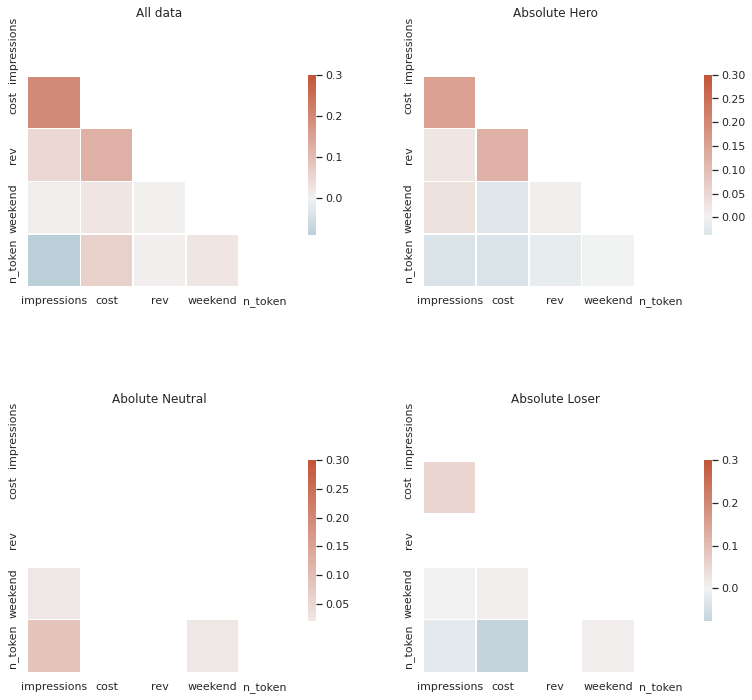

In [65]:
def plot_correlation(corr, ax, title=""):
  ax.set_title(title)
  sns.set_theme(style="white")
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask,  vmax=.3, center=0, cmap=cmap,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


fig, axes = plt.subplots(2, 2, figsize=(13, 13))
# fig.tight_layout(h_pad=1, pad=2)

plot_correlation(df.corr(), axes[0,0], ("All data"))
plot_correlation(df_abs_hero.corr(), axes[0,1], ("Absolute Hero"))
plot_correlation(df_abs_neutral.corr(), axes[1,0], ("Abolute Neutral"))
plot_correlation(df_abs_loser.corr(), axes[1,1], ("Absolute Loser"))





1.   **All data** - **low** and yet **positive** pair-wise correlation between `impressions`, `rev`, `cost` and `weekend`
2. `impression` keep smae correlation ratio on *Abolute Hero and loser* where as in *Neutral* it isn't correlated - lower exposure of `search_item`
2.   We need to go deeper in `search_term` but before let's check correlation with *time*



### Cost vs Rev through time
Let see if the date and day of the week affects our metrics of `cost`, `rev` and `impression` 

In [66]:
df_by_dates_sum = df.groupby('dates').sum().reset_index()
df_by_dates_sum['day'] = df_by_dates_sum.dates.apply(lambda date: date.strftime('%a'))
df_by_dates_sum['cost2rev'] = df_by_dates_sum.cost / df_by_dates_sum.rev


/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


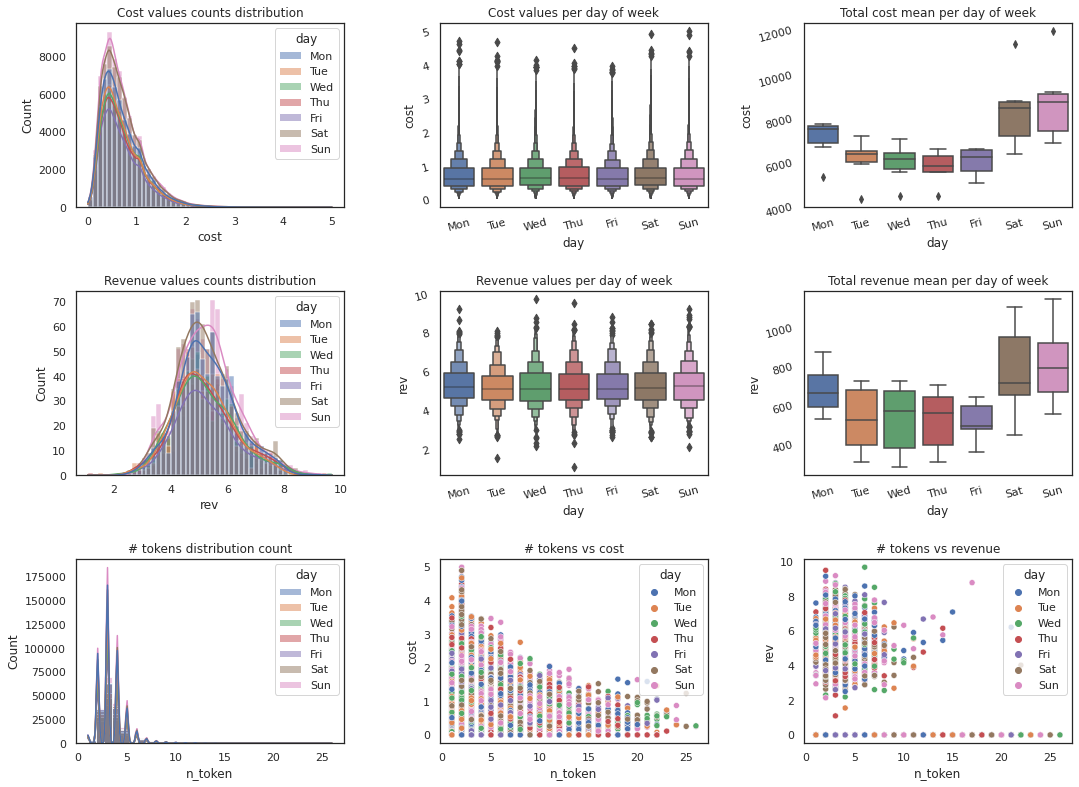

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.tight_layout(h_pad=5, pad=5)

ax=axes[0,0]
ax.set_title("Cost values counts distribution")
sns.histplot(data=df[df.cost!=0], x="cost", kde=True, hue='day', bins=50,  hue_order=order, ax=ax)

ax=axes[0,1]
ax.set_title("Cost values per day of week")
sns.boxenplot(ax=ax, x="day", y="cost", data=df[df.cost!=0],  order=order)
axes[0,1].tick_params(labelrotation=15)

ax=axes[1,0]
ax.set_title("Revenue values counts distribution")
sns.histplot(data=df[df.rev!=0], x="rev", kde=True, hue='day', bins=50,  hue_order=order, ax=ax)

ax=axes[1,1]
ax.set_title("Revenue values per day of week")
sns.boxenplot(ax=ax, x="day", y="rev", data=df[df.rev!=0],  order=order)
ax.tick_params(labelrotation=15)

ax=axes[0,2]
ax.set_title("Total cost mean per day of week")
sns.boxplot(ax=ax, x='day', y="cost", data=df_by_dates_sum, order=order)
ax.tick_params(labelrotation=15)

ax=axes[1,2]
ax.set_title("Total revenue mean per day of week")
sns.boxplot(ax=ax, x='day', y="rev", data=df_by_dates_sum, order=order)
ax.tick_params(labelrotation=15)

ax=axes[2,0]
ax.set_title("# tokens distribution count")
sns.histplot(ax=ax, x="n_token", data=df,  kde=True, hue='day', bins=30,  hue_order=order)

ax=axes[2,1]
ax.set_title("# tokens vs cost")
sns.scatterplot(ax=ax, data=df, x="n_token", y="cost", hue='day', hue_order=order)

ax=axes[2,2]
ax.set_title("# tokens vs revenue")
sns.scatterplot(ax=ax, data=df, x="n_token", y="rev", hue='day', hue_order=order)




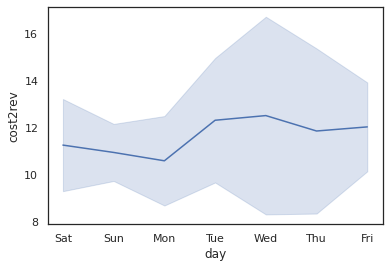

In [ ]:
sns.lineplot(x = 'day', y="cost2rev", ci='sd', data=df_by_dates_sum)

## Model Approach
Till now we have seen distribution of cost/revenue according to number of tokens and according to time. 

We saw that there is a low positive correlation between those features, and we have demonstrated that the weekend is valuable in all domain: search frequency cost and revenue.

We have labeled the data set with ***hero***, ***loser*** and ***neutral*** according to `cost`, `rev` [***criteria***](https://colab.research.google.com/drive/1SbN5f7qauDOiur_tq2yO15OVWsROYEIU#scrollTo=Add_Features_and_Label_data)

Let's try embbeding and fine tuning the `search_term` and then to build a prediction model combine with all the features

> Note: we haven't done anything yet with `impression` feature. We shall take it into consideration when building our prediction model.





###Build the training data

### Concatinate sets of hero, loser and neutral

In [251]:
print("===========================")
print(f"df absolute_hero samples: {df_abs_hero.shape[0]}")
print(f"df absolute_neutral samples: {df_abs_neutral.shape[0]}")
print(f"df absolute_loser samples: {df_abs_loser.shape[0]}")

df absolute_hero samples: 1487
df absolute_neutral samples: 71205
df absolute_loser samples: 166980


In [252]:
df_hero_loser_neutral_downsampled = df_hero_loser_neutral.sample(df_abs_hero.shape[0])
df_abs_loser_downsampled = df_abs_loser.sample(df_abs_hero.shape[0])
df_abs_neutral_downsampled = df_abs_neutral.sample(df_abs_hero.shape[0])
df_hero_loser_downsampled = df_hero_loser.sample(df_abs_hero.shape[0])



In [293]:
loser_downsamples = loser.sample(df_abs_hero.shape[0])

In [294]:
loser_downsamples.shape

(1487, 10)

In [295]:
df_data = pd.concat([df_abs_loser_downsampled, 
                     df_abs_neutral_downsampled, 
                     df_abs_hero, 
                     df_hero_loser_neutral_downsampled,
                     loser_downsamples
])
df_data.shape

(7435, 10)

In [296]:
df_data.cls.value_counts()

loser      3550
neutral    2348
hero       1537
Name: cls, dtype: int64

#####Meta Data
The meta data will include the following features:

*   **`impression`** - will pass through a preprocessing layer to normalize
*   **`day`** - will be transfored to ordinal numbers of day week
*   **`search_term`** - appropriate output of the ***BERT*** layer
*   **`weekend`** - week end day 

From the [*Quick Insights*](https://colab.research.google.com/drive/1SbN5f7qauDOiur_tq2yO15OVWsROYEIU#scrollTo=Quick_insights_on_dataset) above we see that the data is not balanced therefore we will perform a down sampling 

#### Generate *`new_search_term`* 
We will generate a ***`new_search_term`*** that embbeds in *`search_term`* some of the datset features.

In [255]:
def new_search_term(s):
  space = " "
  day = lambda weekend: 'on weekend ' if (weekend) else 'regular day, '
  week_day = lambda day: day + "," + space
  impressions = lambda impr: str(int(impr)) + space + 'impressions'
  cost = lambda cost: 'with cost ' if cost.values==0 else 'with no cost '
  rev = lambda rev: 'with rev ' if rev.values==0 else 'with no revenue '
  search_term = lambda search: search + "," + space

  return(week_day(s.day) + day(s.weekend) + search_term(s.search_term) + impressions(s.impressions))


In [260]:
df_data['new_search_term'] = df_data.apply(new_search_term, axis=1)
df_data.sample(3)

,date,search_term,impressions,cost,rev,dates,day,weekend,n_token,cls,new_search_term
756983,2020-08-21,lowest price blue 12 ft rectangular umbrella,1.0,0.806476,0.0,2020-08-21,Fri,False,7,loser,"Fri, regular day, lowest price blue 12 ft rect..."
339693,2020-08-13,at home bedding,2.0,0.000000,0.0,2020-08-13,Thu,False,3,neutral,"Thu, regular day, at home bedding, 2 impressions"
839616,2020-08-16,bathroom toothbrush holder set,3.0,0.000000,0.0,2020-08-16,Sun,True,4,neutral,"Sun, on weekend bathroom toothbrush holder set..."


#### Class Weights

According to [***above - Quick insights***](https://colab.research.google.com/drive/1SbN5f7qauDOiur_tq2yO15OVWsROYEIU#scrollTo=nmrh21Ms2iXS&line=1&uniqifier=1) we are dealing with imbalanced data therefore we are going to weight the classes

In [297]:
from sklearn.utils.class_weight import compute_class_weight

# this functions get labels values and returns classes list, 
# number of classes and a weighted dictionary of the classes in labels

def get_class_weights(labels, verbose = 0):
  weights = compute_class_weight('balanced',  classes= np.unique(labels), y=labels)
  # creating a dictionary that will be used later for the model fit
  dict_weights = dict(zip(np.arange(len(np.unique(labels))), weights))
  classes = np.unique(labels)
  n_classes = len(classes)
  if verbose:
    print(f"classes: {classes}")
    print(f"n_classes: {n_classes}")
    print(f"dict_weights: {dict_weights}")
    print("==============")
    display(labels.value_counts())

  return classes, n_classes, dict_weights

In [298]:
# creating a dictionary that will be used later for the model fit
classes, n_classes, dict_weights = get_class_weights(df_data.cls, verbose=1)

classes: ['hero' 'loser' 'neutral']
n_classes: 3
dict_weights: {0: 1.6124484927347646, 1: 0.6981220657276995, 2: 1.0555082339579784}


loser      3550
neutral    2348
hero       1537
Name: cls, dtype: int64

#### Training, Validation dataset

In [71]:
from sklearn.model_selection import train_test_split

In [285]:
train_df, remaining = train_test_split(df_data, random_state=23, train_size=0.4, stratify=df_data.cls.values)
valid_df, test_df = train_test_split(remaining, random_state=372, train_size=0.2, stratify=remaining.cls.values)
train_df.shape, valid_df.shape, test_df.shape

((2379, 11), (713, 11), (2856, 11))

In [263]:
train_df.head()

,date,search_term,impressions,cost,rev,dates,day,weekend,n_token,cls,new_search_term
567975,2020-08-13,how much does a heat dish plus cost,1.0,0.350657,0.000000,2020-08-13,Thu,False,8,loser,"Thu, regular day, how much does a heat dish pl..."
856755,2020-08-26,18 1 2 d x 20 w piped outdoor seat cushion,1.0,1.040277,5.590987,2020-08-26,Wed,False,11,hero,"Wed, regular day, 18 1 2 d x 20 w piped outdoo..."
46169,2020-08-26,white decorative art vase color,2.0,1.047319,5.016816,2020-08-26,Wed,False,5,hero,"Wed, regular day, white decorative art vase co..."
706524,2020-08-17,pool float chairs,34.0,0.000000,0.000000,2020-08-17,Mon,False,3,neutral,"Mon, regular day, pool float chairs, 34 impres..."
472750,2020-08-10,best pool patio furniture,3.0,0.000000,0.000000,2020-08-10,Mon,False,4,neutral,"Mon, regular day, best pool patio furniture, 3..."


In [299]:
import tensorflow as tf

with tf.device('/cpu:0'):
  batch_size = 32
  train_labels = pd.get_dummies(train_df.cls.values)
  val_labels = pd.get_dummies(valid_df.cls.values)
  test_labels = pd.get_dummies(test_df.cls.values)
   
  train_data = tf.data.Dataset.from_tensor_slices((train_df.new_search_term.values, train_labels)).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
  val_data = tf.data.Dataset.from_tensor_slices((valid_df.new_search_term.values, val_labels)).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
  test_data = tf.data.Dataset.from_tensor_slices((test_df.new_search_term.values, test_labels)).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)

  for text, label in train_data.take(1):
    print(text.shape)
    print(label.shape)

(32,)
(32, 3)


### Build Bert Model

#### Import BERT model and get embeding vectors

In [97]:
# !pip install transformers
!pip install tensorflow_text
# from transformers import BertTokenizer, TFBertModel, BertConfig
# from tokenizers import BertWordPieceTokenizer

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [300]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_hub as hub
import tensorflow_text as text

In [301]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=False)
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True, name='bert')


In [302]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [184]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates",
    "Sat",
    "Saturday",
    "Mon",
    "monday wonderful day",
    "Monday is a great day",
    "Monday",
    "mon"
]
)

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [185]:
e[5].shape

TensorShape([768])

In [268]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[10]],[e[9]])

array([[0.98893964]], dtype=float32)

In [303]:
def create_model():
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  # meta_input = 
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)

  # Neural network layers
  l = tf.keras.layers.Dropout(0.5, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(3, activation='softmax', name="output")(l)

  # Use inputs and outputs to construct a final model
  return tf.keras.Model(inputs=[text_input], outputs = [l])

In [304]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
working_dir = "/content/drive/MyDrive/Colab Notebooks/Kenshoo"

def get_callbacks():
  
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                            mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  # define checkpoints

  checkpoint_path = working_dir + "/checkpoints/cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  return [reduce_lr, early_stop, cp_callback]

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                   

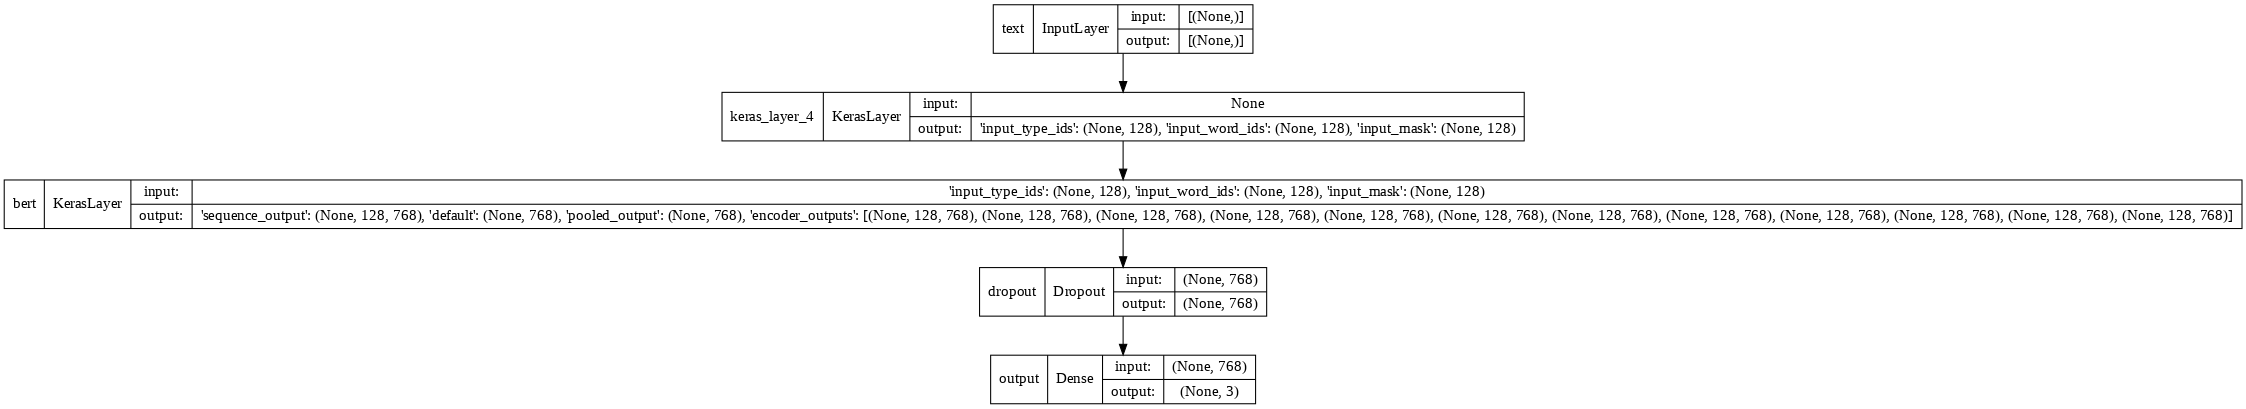

In [305]:
METRICS = [
      'accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]



model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)
model.summary()
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)


### Train

In [306]:

# Train model
epochs = 3

history = model.fit(train_data,
                    epochs=epochs,
                    callbacks=get_callbacks(),
                    validation_data=val_data,
                    class_weight=dict_weights)

                                     

Epoch 1/3
75/75 [==============================] - ETA: 0s - loss: 1.2425 - accuracy: 0.3506 - precision: 0.3316 - recall: 0.1585 - tp: 377.0000 - fp: 760.0000 - tn: 3998.0000 - fn: 2002.0000 - prc: 0.3367
Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Kenshoo/checkpoints/cp.ckpt
75/75 [==============================] - 121s 1s/step - loss: 1.2425 - accuracy: 0.3506 - precision: 0.3316 - recall: 0.1585 - tp: 377.0000 - fp: 760.0000 - tn: 3998.0000 - fn: 2002.0000 - prc: 0.3367 - val_loss: 1.1041 - val_accuracy: 0.4095 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1426.0000 - val_fn: 713.0000 - val_prc: 0.3758 - lr: 2.0000e-05
Epoch 2/3
75/75 [==============================] - ETA: 0s - loss: 1.1548 - accuracy: 0.3733 - precision: 0.4186 - recall: 0.1816 - tp: 432.0000 - fp: 600.0000 - tn: 4158.0000 - fn: 1947.0000 - prc: 0.3838
Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Kenshoo/chec

##Evaluating

In [154]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)

def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [150]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [147]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def plot_confusion_matrix(true_labels, predictions, classes):
  lb = LabelBinarizer()
  lb.fit(classes)
  predictions_class = lb.inverse_transform(predictions)
  cm = confusion_matrix(true_labels, predictions_class, labels=lb.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
  disp.plot()
  cls_report = classification_report(true_labels, predictions_class, output_dict=True)
  display(pd.DataFrame(cls_report))

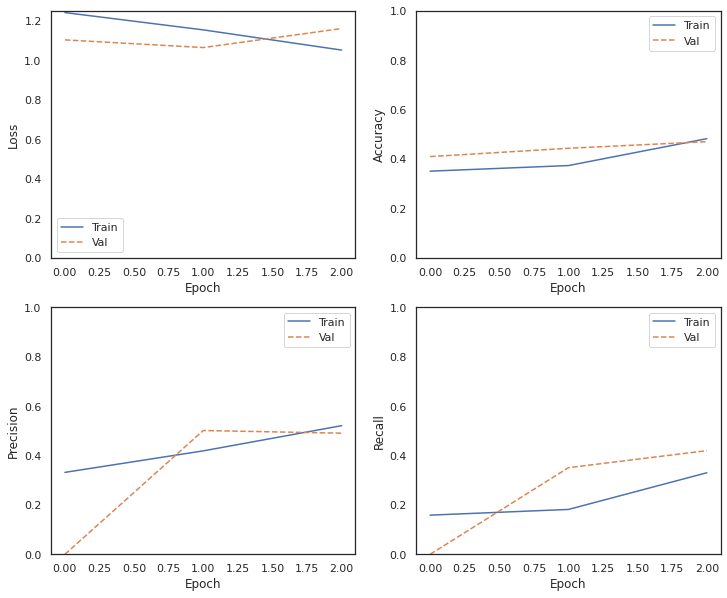

In [307]:
plot_metrics(history)

In [314]:
test_sample, test_remain = train_test_split(test_df, random_state=42, train_size=0.1, stratify=test_df.cls.values)
test_sample.shape

(285, 11)

In [315]:
test_sample.cls.value_counts()

neutral    112
loser       99
hero        74
Name: cls, dtype: int64

In [161]:
test_df.cls.value_counts()

neutral    639
loser      552
hero       416
Name: cls, dtype: int64

In [125]:
eval_df = test_df.sample()

(3213, 11)

In [317]:
predictions = model.predict(test_sample.new_search_term)

In [309]:
predictions.shape

(250, 3)

In [131]:
classes

array(['hero', 'loser', 'neutral'], dtype=object)

,hero,loser,neutral,accuracy,macro avg,weighted avg
precision,0.400000,1.000000,0.506757,0.459649,0.635586,0.650375
recall,0.729730,0.020202,0.669643,0.459649,0.473192,0.459649
f1-score,0.516746,0.039604,0.576923,0.459649,0.377758,0.374651
support,74.000000,99.000000,112.000000,0.459649,285.000000,285.000000


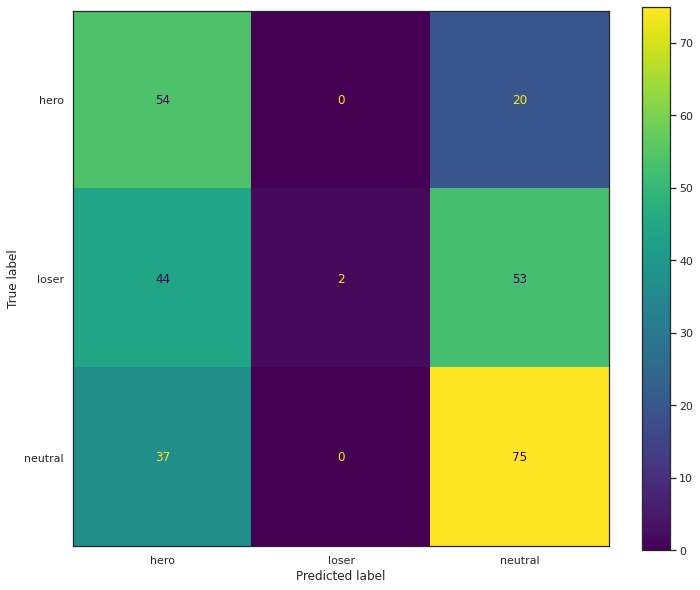

In [318]:
plot_confusion_matrix(test_sample.cls, predictions, classes)

In [226]:
def create_combined_model():
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)
  output_text = tf.keras.layers.Dropout(0.5, name="dropout")(outputs['pooled_output'])
  output_text = tf.keras.Model(inputs=[text_input], outputs=[output_text])

  # meta data layer
  meta_input = tf.keras.layers.Input(shape=(9,), dtype=tf.int32, name="meta")
  output_meta = tf.keras.layers.Dense(8, activation='relu')(meta_input)
  output_meta = tf.keras.layers.Dense(4, activation='relu')(output_meta)
  output_meta = tf.keras.Model(inputs=[meta_input], outputs=[output_meta])

  combined = tf.keras.layers.concatenate([output_text.output, output_meta.output])

  x = tf.keras.layers.BatchNormalization()(combined)
  x = tf.keras.layers.Dropout(0.5, name="drop_combined")(x)
  x = tf.keras.layers.Dense(4, activation='relu')(x)


  cls_pred = tf.keras.layers.Dense(3, activation='softmax', name="cls_pred")(x)
  # Stick a department classifier on top of the features
  rev_pred = tf.keras.layers.Dense(2, activation='linear', name="rev_cost")(x)

  # Use inputs and outputs to construct a final model
  return tf.keras.Model(inputs=[text_input, meta_input], 
                                  outputs = [cls_pred, rev_pred])

In [227]:
combined = create_combined_model()
combined.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                               

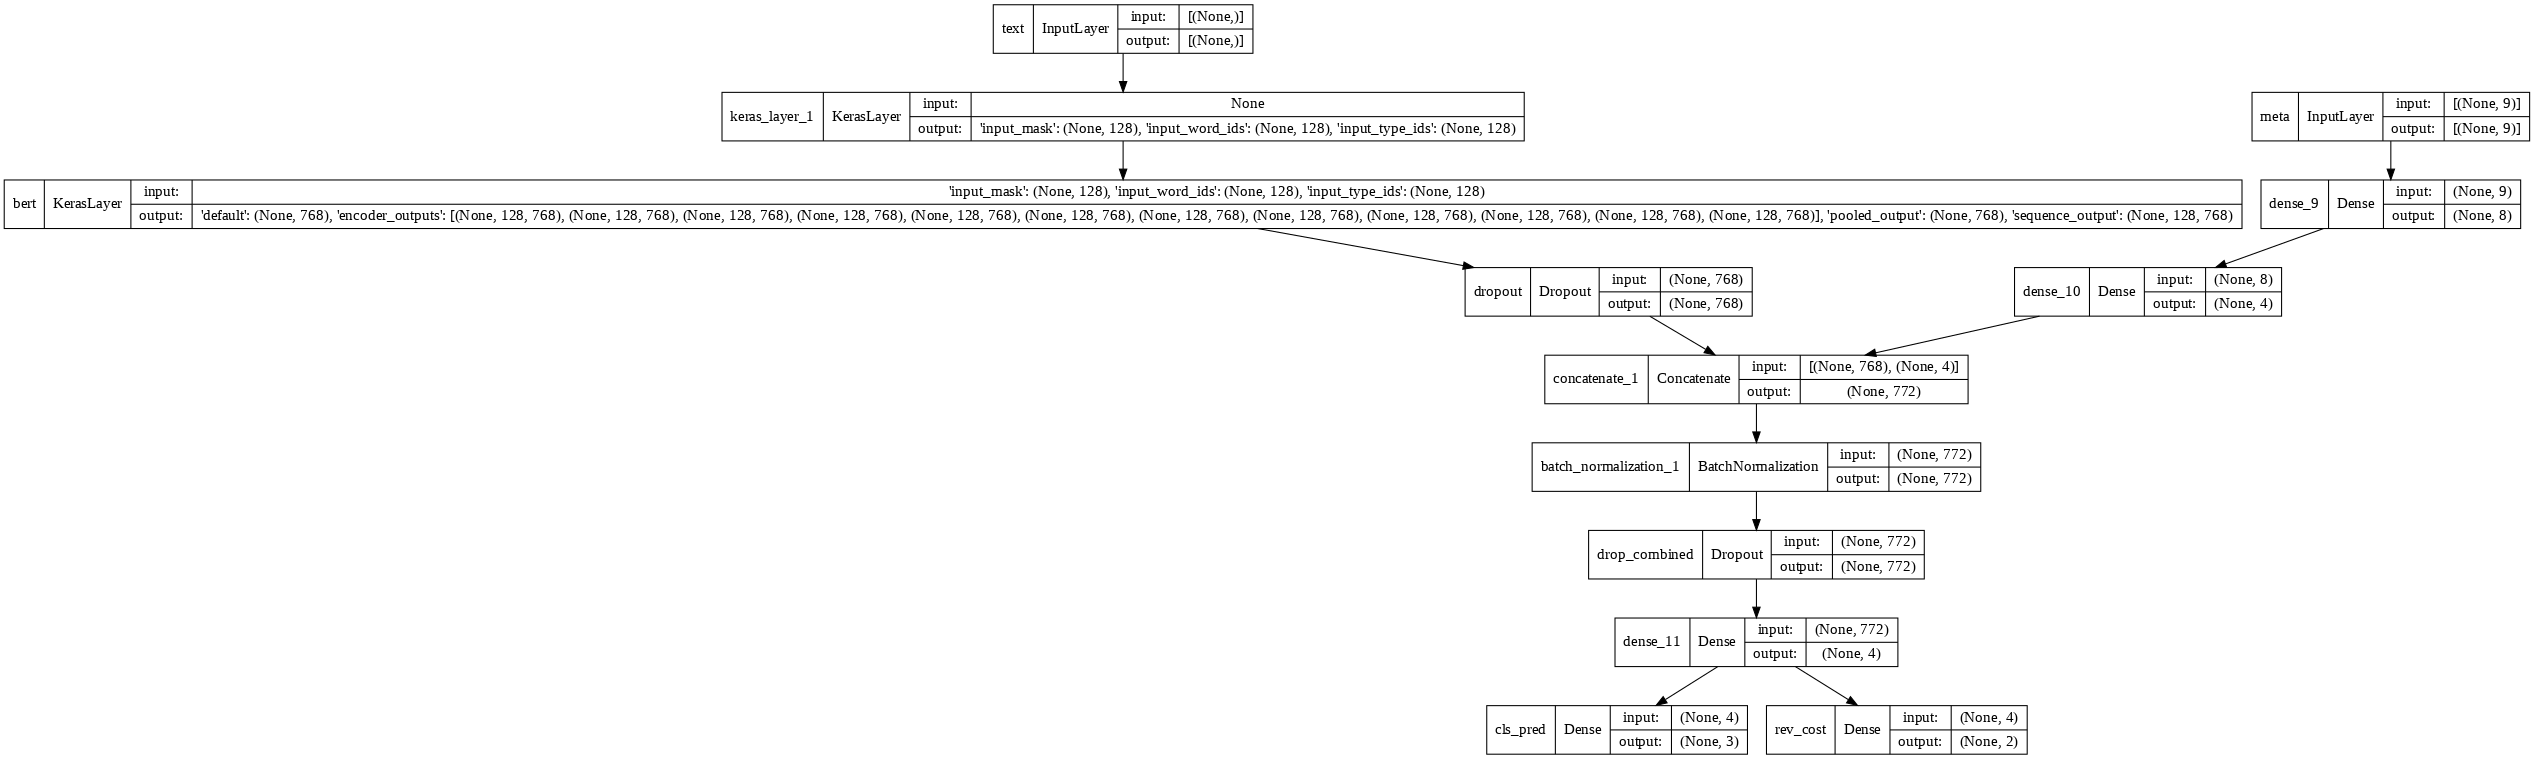

In [228]:
keras.utils.plot_model(model=combined, show_shapes=True, dpi=76)